## Data Exploration
## Content
  * Load data 
  * Investigate SalePrice
  * Remove bad fields
  * Dealing with missing data
  * Correlation matrix for numerical features
  * Encode categorical features to numerical
  * Correlation matrix for encoded categorical features
  * Investigate Logarifm transformations
  * Investigate Pow transformations

In [1]:
import os
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from scipy import stats
from IPython.display import display, HTML
from sklearn.model_selection import train_test_split
from pymongo import MongoClient
import warnings
import sklearn.linear_model as linear_model
%matplotlib inline

warnings.filterwarnings('ignore')

In [2]:
MONGODB_URL = os.environ['MONGODB_URI']
client = MongoClient(MONGODB_URL)
db = client.get_default_database()

In [3]:
data = db["train_data"].find({})
df_train = pd.DataFrame(list(data))
df_train.drop(columns=["_id"], inplace=True)
df_train.shape

(1460, 79)

In [4]:
data = db["test_data"].find({})
df_test = pd.DataFrame(list(data))
df_test.drop(columns=["_id"], inplace=True)
df_test.shape

(1468, 79)

In [5]:
full_frame = pd.concat([df_train, df_test])
full_frame.shape

(2928, 79)

## Investigate SalePrice

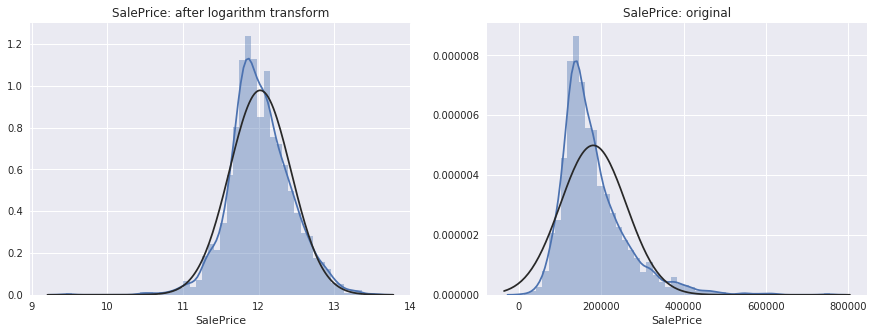

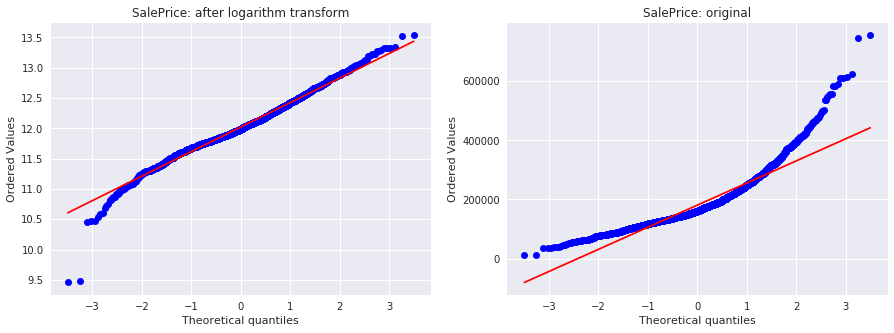

In [6]:
#histogram
sns.set(rc={'figure.figsize':(15,5)})
fig, ax = plt.subplots(1,2)
sns.distplot(np.log1p(full_frame['SalePrice']), fit=norm, ax=ax[0])
sns.distplot(full_frame['SalePrice'], fit=norm, ax=ax[1])
ax[0].set_title("SalePrice: after logarithm transform")
ax[1].set_title("SalePrice: original")
fig.show()

#normal probability plot
fig, ax = plt.subplots(1,2)
stats.probplot(np.log1p(full_frame['SalePrice']), plot=ax[0])
stats.probplot(full_frame['SalePrice'], plot=ax[1])
ax[0].set_title("SalePrice: after logarithm transform")
ax[1].set_title("SalePrice: original")
fig.show()

You should choose True value for applyLogTransformForSalePrice if after logarithm transform SalePrice became more corresponded with normal distribution

In [7]:
applyLogTransformForSalePrice = True

In [8]:
if applyLogTransformForSalePrice:
    full_frame['SalePrice'] = np.log1p(full_frame['SalePrice'])

### Remove bad fields

Choose fields that cannot be taken for training for some reasons

In [9]:
features = set(full_frame.columns.tolist())
features.remove('OverallQual')
features.remove('KitchenQual')
features.remove('HeatingQC')
features.remove('ExterQual')

In [10]:
features.remove('SalePrice')

In [11]:
len(features)

74

### Dealing with missing data

In [12]:
#missing data
total = full_frame.isnull().sum().sort_values(ascending=False)
percent = (full_frame.isnull().sum()/full_frame.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(5)

,Total,Percent
YrSold,0,0.0
Foundation,0,0.0
ExterCond,0,0.0
ExterQual,0,0.0
Exterior1st,0,0.0


In [13]:
# remove features where data is missed more then 5 times
features = features.difference(set((missing_data[missing_data['Total'] > 5]).index.tolist()))

In [14]:
# remove left images where data is missed
full_frame = full_frame.drop(full_frame.loc[full_frame.isnull().any(axis=1)].index)
full_frame[list(features)].isnull().sum().max() #just checking that there's no missing data missing...

0

In [15]:
# features left
len(features)

74

### Lists of numerical and categorical features

In [16]:
# get categorical features list
g = {k.name: v for k, v in full_frame[list(features)].columns.to_series().groupby(full_frame.dtypes).groups.items()}
categorical = g["object"].tolist()
numerical = g["float64"].tolist() + g["int64"].tolist()
g

{'float64': Index(['MasVnrArea', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtFinSF2', 'BsmtUnfSF',
        'TotalBsmtSF', 'BsmtFinSF1', 'GarageArea', 'LotFrontage', 'GarageCars'],
       dtype='object'),
 'int64': Index(['YrSold', 'LowQualFinSF', 'HalfBath', 'LotArea', 'BedroomAbvGr',
        '3SsnPorch', 'PoolArea', 'Fireplaces', 'YearBuilt', '1stFlrSF',
        'GrLivArea', 'ScreenPorch', 'YearRemodAdd', 'MiscVal', 'OpenPorchSF',
        'OverallCond', 'EnclosedPorch', 'FullBath', 'KitchenAbvGr',
        'TotRmsAbvGrd', 'WoodDeckSF', '2ndFlrSF'],
       dtype='object'),
 'object': Index(['MoSold', 'RoofMatl', 'Utilities', 'CentralAir', 'HouseStyle',
        'LotConfig', 'MiscFeature', 'SaleType', 'Street', 'GarageFinish',
        'PoolQC', 'GarageCond', 'LandContour', 'MasVnrType', 'Electrical',
        'BsmtExposure', 'BsmtCond', 'Condition1', 'RoofStyle', 'BsmtQual',
        'SaleCondition', 'Exterior2nd', 'Condition2', 'PavedDrive',
        'GarageQual', 'FireplaceQu', 'ExterCond', 'Foun

### Correlation matrix for numerical features

In [17]:
# numerical features list
numerical

['MasVnrArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'BsmtFinSF1',
 'GarageArea',
 'LotFrontage',
 'GarageCars',
 'YrSold',
 'LowQualFinSF',
 'HalfBath',
 'LotArea',
 'BedroomAbvGr',
 '3SsnPorch',
 'PoolArea',
 'Fireplaces',
 'YearBuilt',
 '1stFlrSF',
 'GrLivArea',
 'ScreenPorch',
 'YearRemodAdd',
 'MiscVal',
 'OpenPorchSF',
 'OverallCond',
 'EnclosedPorch',
 'FullBath',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'WoodDeckSF',
 '2ndFlrSF']

In [18]:
len(numerical)

32

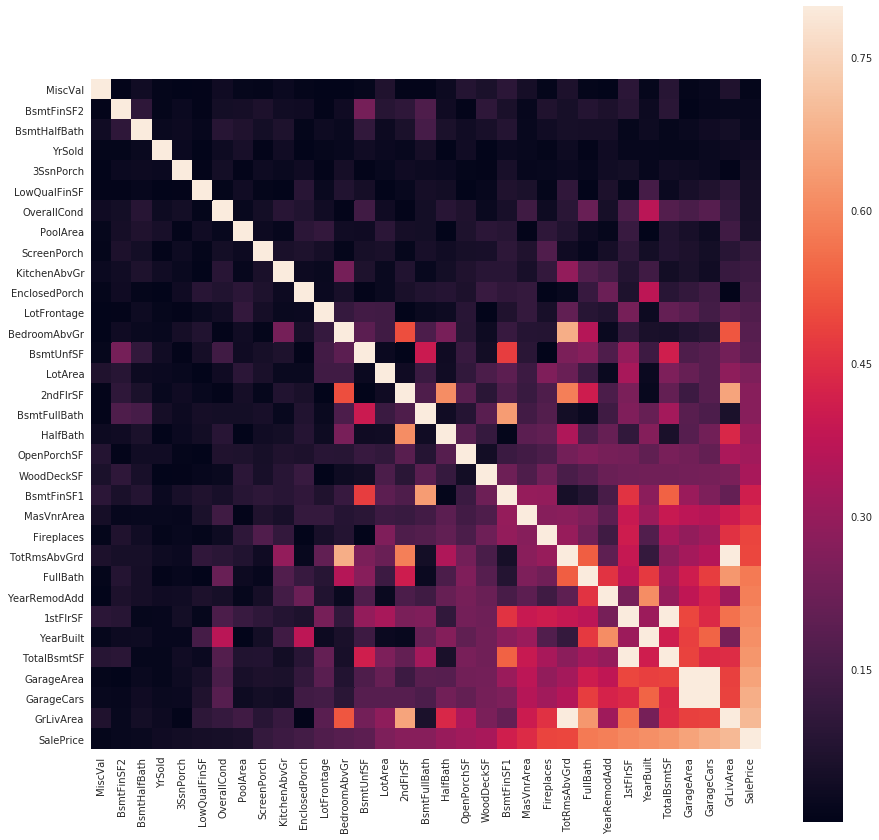

In [19]:
numerical_df = full_frame[numerical + ['SalePrice']].copy(True)

#correlation matrix
corrmat = numerical_df.corr().abs()

# sort columns in df by SalePrice correlation
cols = corrmat.sort_values(["SalePrice"])['SalePrice'].index
# get new correlation matrix with sorted columns
cm = numerical_df[cols].corr().abs()
# show plot
sns.set(rc={'figure.figsize':(15,15)})
sns.heatmap(cm, vmax=.8, square=True, yticklabels=cols.values, xticklabels=cols.values)

In [20]:
# dealing with features which highly correlated with each other
# features that correlated with each other more then this threshold should be considered to remove
# Please enter threshold
thresh = 0.7

In [21]:
# mask to go through only under diagonal triangle
mask = np.ones(cm.shape,dtype='bool')
mask[np.triu_indices(len(cm))] = False

highly_corr_cm = cm.drop(index=['SalePrice'],columns=['SalePrice'])[(cm>thresh)&mask].dropna(axis=0, how='all').dropna(axis=1, how='all')
highly_corr_cm = highly_corr_cm.append(cm['SalePrice'][highly_corr_cm.columns])
highly_corr_cm['SalePrice'] = cm['SalePrice'][highly_corr_cm.index]
highly_corr_cm

,TotRmsAbvGrd,1stFlrSF,GarageArea,SalePrice
TotalBsmtSF,NaN,0.800645,NaN,0.625354
GarageCars,NaN,NaN,0.889901,0.674760
GrLivArea,0.807717,NaN,NaN,0.695690
SalePrice,0.492102,0.602716,0.650683,1.000000


In [22]:
# Please enter features that should be removed according to table above 
columns_to_remove = [
    "1stFlrSF",
    "GarageArea",
    "TotRmsAbvGrd"]

In [23]:
numerical_df.drop(columns=columns_to_remove, inplace=True)

Define attributes with highest correlation and transformation type which should be applied for it. Please enter wished correlation threshold for numerical values:

In [24]:
corr_threshold_for_num_features = 0.30

In [25]:
numerical_df_log = numerical_df.copy(True)
numerical_df_log = numerical_df_log.drop(columns=['SalePrice']).apply(lambda x: np.log1p(x))
numerical_df_log["SalePrice"] = numerical_df["SalePrice"]
corrmat_log = numerical_df_log.corr().abs()

numerical_df_pow = numerical_df.copy(True)
numerical_df_pow = numerical_df_pow.drop(columns=['SalePrice']).apply(lambda x: x**2)
numerical_df_pow["SalePrice"] = numerical_df["SalePrice"]
corrmat_pow = numerical_df_pow.corr().abs()

magic_num_table = pd.DataFrame()
magic_num_table["log"] = corrmat_log["SalePrice"]
magic_num_table["pow"] = corrmat_pow["SalePrice"]
magic_num_table["origin"] = corrmat["SalePrice"]
magic_num_table["highest_value"] = magic_num_table.max(axis=1)

magic_num_table["transform_type"] = "magic_num_table"
magic_num_table["transform_type"][magic_num_table["log"] == magic_num_table["highest_value"]] = "log"
magic_num_table["transform_type"][magic_num_table["pow"] == magic_num_table["highest_value"]] = "pow"
magic_num_table["transform_type"][magic_num_table["origin"] == magic_num_table["highest_value"]] = "origin"

magic_num_table.drop(index=["SalePrice"], inplace=True)

magic_num_table = magic_num_table.sort_values('origin', ascending=False)
magic_num_table = magic_num_table[magic_num_table["origin"] > corr_threshold_for_num_features]
magic_num_table

,log,pow,origin,highest_value,transform_type
GrLivArea,0.722939,0.610770,0.695690,0.722939,log
GarageCars,0.635571,0.659616,0.674760,0.674760,origin
TotalBsmtSF,0.378799,0.495537,0.625354,0.625354,origin
YearBuilt,0.613511,0.617469,0.615517,0.617469,pow
YearRemodAdd,0.585769,0.585914,0.585844,0.585914,pow
FullBath,0.570073,0.561707,0.577183,0.577183,origin
Fireplaces,0.508623,0.373818,0.488796,0.508623,log
MasVnrArea,0.434089,0.323677,0.442935,0.442935,origin
BsmtFinSF1,0.244522,0.320834,0.410873,0.410873,origin
WoodDeckSF,0.353217,0.200505,0.333079,0.353217,log


selected numerical features

In [26]:
magic_num_table["transform_type"]

GrLivArea          log
GarageCars      origin
TotalBsmtSF     origin
YearBuilt          pow
YearRemodAdd       pow
FullBath        origin
Fireplaces         log
MasVnrArea      origin
BsmtFinSF1      origin
WoodDeckSF         log
OpenPorchSF        log
HalfBath           log
Name: transform_type, dtype: object

### Encode categorical features to numerical

In [27]:
# categorical features list
categorical

['MoSold',
 'RoofMatl',
 'Utilities',
 'CentralAir',
 'HouseStyle',
 'LotConfig',
 'MiscFeature',
 'SaleType',
 'Street',
 'GarageFinish',
 'PoolQC',
 'GarageCond',
 'LandContour',
 'MasVnrType',
 'Electrical',
 'BsmtExposure',
 'BsmtCond',
 'Condition1',
 'RoofStyle',
 'BsmtQual',
 'SaleCondition',
 'Exterior2nd',
 'Condition2',
 'PavedDrive',
 'GarageQual',
 'FireplaceQu',
 'ExterCond',
 'Foundation',
 'MSSubClass',
 'BsmtFinType1',
 'GarageType',
 'BldgType',
 'Fence',
 'Alley',
 'LandSlope',
 'LotShape',
 'BsmtFinType2',
 'Exterior1st',
 'MSZoning',
 'Neighborhood',
 'Heating',
 'Functional']

In [28]:
len(categorical)

42

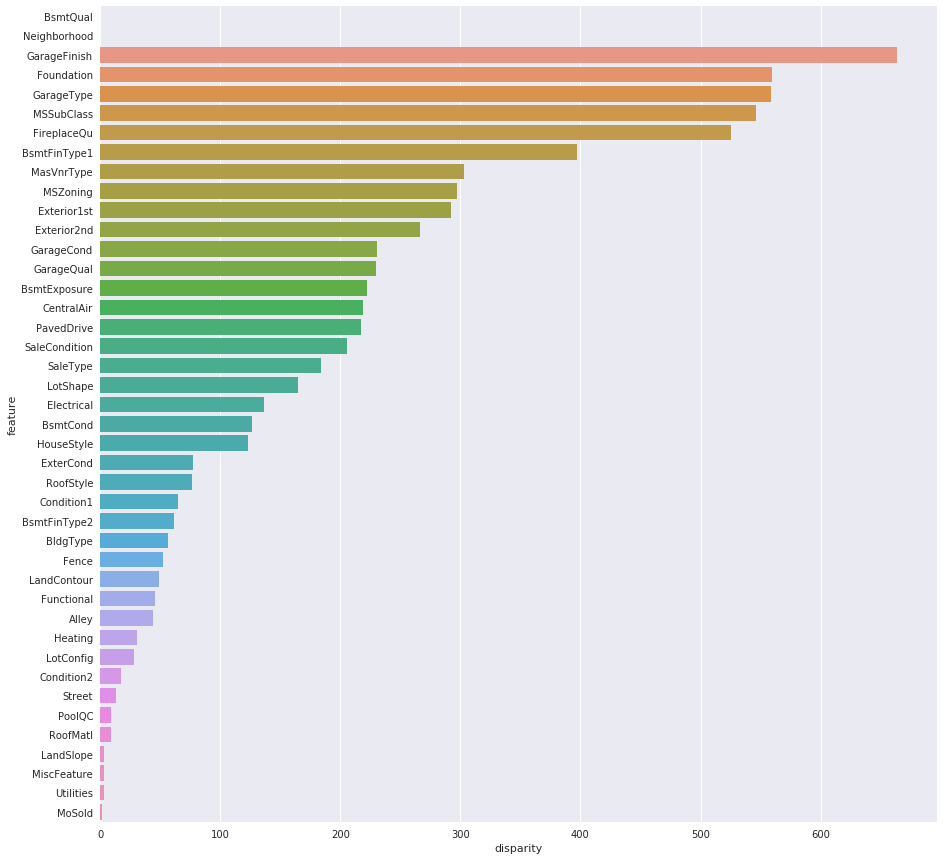

In [29]:
# perform ANOVA test 

def anova(frame, qualitative):
    anv = pd.DataFrame()
    anv['feature'] = qualitative
    pvals = []
    for c in qualitative:
        samples = []
        for cls in frame[c].unique():
            s = frame[frame[c] == cls]['SalePrice'].values
            samples.append(s.astype(np.float64))
        pval = stats.f_oneway(*samples)[1]
        pvals.append(pval)
    anv['pval'] = pvals
    return anv.sort_values('pval')

a = anova(full_frame.copy(True), g["object"].tolist())
a['disparity'] = np.log(1./a['pval'].values)
sns.set(rc={'figure.figsize':(15,15)})
sns.barplot(data=a, y='feature', x='disparity')

In [30]:
# perform encoding

dummies = {}

def encode(frame, feature):
    ordering = pd.DataFrame()
    ordering['val'] = frame[feature].unique()
    ordering.index = ordering.val
    ordering['spmean'] = frame[[feature, 'SalePrice']].groupby(feature).mean()['SalePrice']
    ordering = ordering.sort_values('spmean')
    ordering['ordering'] = range(1, ordering.shape[0]+1)
    ordering = ordering['ordering'].to_dict()
    
    for cat, o in ordering.items():
        frame.loc[frame[feature] == cat, feature] = o
    
    return ordering
    
for c in categorical:  
    dummies[c] = encode(full_frame, c)

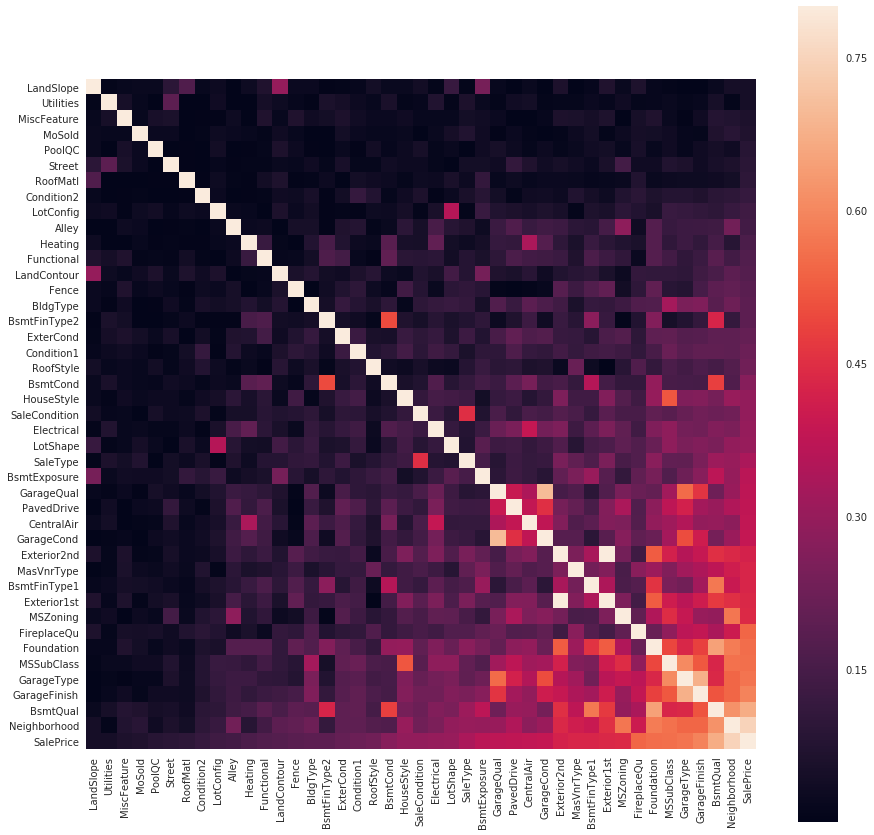

In [31]:
categorical_df = full_frame[categorical + ['SalePrice']]
categorical_df['SalePrice'] = np.log1p(categorical_df['SalePrice'])

#correlation matrix
corrmat = categorical_df.corr().abs()
cols = corrmat.sort_values(["SalePrice"])['SalePrice'].index
cm = categorical_df[cols].corr().abs()
sns.set(rc={'figure.figsize':(15,15)})
sns.heatmap(cm, vmax=.8, square=True, yticklabels=cols.values, xticklabels=cols.values)

In [32]:
mask = np.ones(cm.shape,dtype='bool')
mask[np.triu_indices(len(cm))] = False

In [33]:
# dealing with features which highly correlated with each other
# features that correlated with each other more then this threshold should be considered to remove
# Please enter threshold
thresh = 0.7

In [34]:
highly_corr_cm = cm.drop(index=['SalePrice'],columns=['SalePrice'])[(cm>thresh)&mask].dropna(axis=0, how='all').dropna(axis=1, how='all')
highly_corr_cm = highly_corr_cm.append(cm['SalePrice'][highly_corr_cm.columns])
highly_corr_cm['SalePrice'] = cm['SalePrice'][highly_corr_cm.index]
highly_corr_cm

,Exterior2nd,SalePrice
Exterior1st,0.895722,0.436326
SalePrice,0.418892,1.000000


In [35]:
# Please enter features that should be removed according to table above 
columns_to_remove = ["Exterior2nd"]

In [36]:
categorical_df.drop(columns=columns_to_remove, inplace=True)

Define attributes with highest correlation and transformation type which should be applied for it. Please enter wished correlation threshold for categorical values:

In [37]:
corr_threshold_for_cat_features = 0.4

In [38]:
categorical_df_log = categorical_df.copy(True)
categorical_df_log = categorical_df_log.drop(columns=['SalePrice']).apply(lambda x: np.log1p(x))
categorical_df_log["SalePrice"] = categorical_df["SalePrice"]
corrmat_log = categorical_df_log.corr().abs()

categorical_df_pow = categorical_df.copy(True)
categorical_df_pow = categorical_df_pow.drop(columns=['SalePrice']).apply(lambda x: x**2)
categorical_df_pow["SalePrice"] = categorical_df["SalePrice"]
corrmat_pow = categorical_df_pow.corr().abs()

magic_cat_table = pd.DataFrame()
magic_cat_table["log"] = corrmat_log["SalePrice"]
magic_cat_table["pow"] = corrmat_pow["SalePrice"]
magic_cat_table["origin"] = corrmat["SalePrice"]
magic_cat_table["highest_value"] = magic_cat_table.max(axis=1)

magic_cat_table["transform_type"] = "magic_cat_table"
magic_cat_table["transform_type"][magic_cat_table["log"] == magic_cat_table["highest_value"]] = "log"
magic_cat_table["transform_type"][magic_cat_table["pow"] == magic_cat_table["highest_value"]] = "pow"
magic_cat_table["transform_type"][magic_cat_table["origin"] == magic_cat_table["highest_value"]] = "origin"

magic_cat_table.drop(index=["SalePrice"], inplace=True)

magic_cat_table = magic_cat_table.sort_values('origin', ascending=False)
magic_cat_table = magic_cat_table[magic_cat_table["origin"] > corr_threshold_for_cat_features]
magic_cat_table

,log,pow,origin,highest_value,transform_type
Neighborhood,0.705929,0.735122,0.747121,0.747121,origin
BsmtQual,0.634622,0.689034,0.669471,0.689034,pow
GarageFinish,0.598447,0.572040,0.593251,0.598447,log
GarageType,0.555659,0.565946,0.568491,0.568491,origin
MSSubClass,0.538201,0.554533,0.557056,0.557056,origin
Foundation,0.526083,0.564793,0.553253,0.564793,pow
FireplaceQu,0.537296,0.541557,0.542279,0.542279,origin
MSZoning,0.440150,0.430076,0.437928,0.440150,log
Exterior1st,0.427985,0.432667,0.436326,0.436326,origin
BsmtFinType1,0.406436,0.450186,0.431084,0.450186,pow


selected categorical features

In [39]:
magic_cat_table["transform_type"]

Neighborhood    origin
BsmtQual           pow
GarageFinish       log
GarageType      origin
MSSubClass      origin
Foundation         pow
FireplaceQu     origin
MSZoning           log
Exterior1st     origin
BsmtFinType1       pow
MasVnrType      origin
Name: transform_type, dtype: object

### Summarize

In [40]:
pd.concat([magic_cat_table, magic_num_table]).sort_values('origin', ascending=False)

,log,pow,origin,highest_value,transform_type
Neighborhood,0.705929,0.735122,0.747121,0.747121,origin
GrLivArea,0.722939,0.610770,0.695690,0.722939,log
GarageCars,0.635571,0.659616,0.674760,0.674760,origin
BsmtQual,0.634622,0.689034,0.669471,0.689034,pow
TotalBsmtSF,0.378799,0.495537,0.625354,0.625354,origin
YearBuilt,0.613511,0.617469,0.615517,0.617469,pow
GarageFinish,0.598447,0.572040,0.593251,0.598447,log
YearRemodAdd,0.585769,0.585914,0.585844,0.585914,pow
FullBath,0.570073,0.561707,0.577183,0.577183,origin
GarageType,0.555659,0.565946,0.568491,0.568491,origin


### Save results for future learning

In [41]:
if applyLogTransformForSalePrice:
    full_frame['SalePrice'] = np.expm1(full_frame['SalePrice'])
notebook_collection = db["notebook"]
notebook_collection.remove({})
notebook_collection.insert_many(full_frame.to_dict('records'))